# 实现Adaboost

boost集成基分类器的方式是通过每一轮调整训练数据的权重或概率分布，将弱分类器组和成一个强分类器  
对于Adaboost来说，  
每一次提高前一轮被若分类器错误分类的样本的权重，降低那些被正确分类的样本权重。  
最终的分类器是这些基分类器的线性组合，其中分类误差率小的权重大，分类误差大的权重小

Adaboost最终的分类器为
$G(x) = sign(f(x))=sign\big(\sum\limits_{m=1}^M\alpha_mG_m(x)\big)$  
其中$\alpha_m= \frac{1}{2}log(\frac{1-e_m}{e_m})$
e为错误率

每次样本的权重是如何改变的呢？  
第一轮的时候，训练数据的权重分布为1/N  
当完成m轮训练后
$$D_{m+1} = (w_{m+1,1},w_{m+1,2},...w_{m+1,N})$$ 
$$w_{m+1,i}=\frac{w_{m,i}}{Z_m}exp(-\alpha_my_iGm(x_i))$$
上面的式子还可以改写成
$$
w_{m+1,i}=\begin{cases}\frac{w_{m,i}}{Z_m}e^{-\alpha_m} ,& Gm(x_i)=y_i\\\frac{w_{m,i}}{Z_m}e^{\alpha_m} ,& Gm(x_i)\not=y_i\end{cases}
$$
也就是对于G_m分类器来说,如果分类正确，则在下一次分类时，减小这个样本对应的权重，如果分类错误，则在下一次分类时，增加这个样本对应的权重  
其中$Z_m$是规范化因子，让算出来的$w_{m+1,i}$的总和为1  
故$Z_m=\sum\limits_{i=1}^Nw_{m,i}exp(-\alpha_my_iGm(x_i))$  
或者简单理解为$sum(D_{m+1})$

算法过程
1. 初始化训练数据的权值分布
2. 对m=1,2,...,M  
    a. 使用具有权值分布的Dm训练数据集学习，得到基本分类器Gm  
    b. 计算Gm(x)在训练数据集上的分类误差（注意测试的训练集是有权值的）  
    c. 计算Gm(x)对应的系数，即$\alpha_m$  
    d. 更新训练数据集的权值分布  
    结束的标志为构建的f(x)的错误率为0或者弱分类器的个数达到指定值
3. 构建基本分类器的线性组合
    $$f(x)=\sum\limits_{m=1}^M\alpha_mG_m(x)$$
    最终的分类器为$G(x) = sign(f(x))=sign(\sum\limits_{m=1}^M\alpha_mG_m(x))$

# 基于单层决策树构建若分类器

单层决策树又名决策树桩，只有一个决策分枝，以某一个维度进行划分。
在构建单层决策树的时候，在所有的特征中进行便利，选择加权错误率最低的。

In [3]:
import numpy as np
import matplotlib.pyplot as plt
data=np.array([[1.0,2.1,1.0],
                [1.5,1.6,1.0],
               [1.3,1.0,-1.0],
               [1.0,1.0,-1.0],
               [2.0,1.0,1.0]]
             )
X=data[:,:-1]
y=data[:,-1]

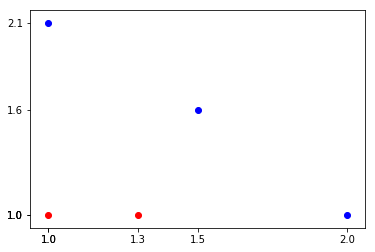

In [4]:
plt.scatter(X[y==1,0],X[y==1,1],c='blue')
plt.scatter(X[y==-1,0],X[y==-1,1],c='red')
plt.xticks(X[:,0])
plt.yticks(X[:,1])
plt.show()

In [5]:
def set_stump(X,y,D):
    minerror = float("inf")
    bestsplit = -1 #最佳分割点
    bestlabel = -1 #最佳分割特征
    beststump={}
    for label in range(X.shape[1]):
        value = np.append(X[:,label],np.array([X[:,label].min()-1,X[:,label].max()+1]))
        index = np.argsort(value)
        for i in range(1,len(index)):
            if value[index[i-1]] != value[index[i]]:
                split = (value[index[i-1]] + value[index[i]])/2
                indexleft = X[:,label] < split
                for _ in [1,-1]:#依此假设划分的左侧的决策为-1，+1
                    res = np.ones(len(y))
                    res[indexleft] = -1
                    res = res*_
                    err = np.sum((res != y)*D)
                    if err < minerror:
                        minerror = err
                        bestlabel = label
                        bestsplit = split
                        symbol = _
                        bestres = res
                        
    beststump["bestlabel"]=bestlabel
    beststump["bestsplit"]=bestsplit
    beststump["symbol"]=symbol
    return beststump,minerror,bestres

In [6]:
set_stump(X,y,np.ones(len(y))/len(y))

({'bestlabel': 0, 'bestsplit': 1.4, 'symbol': 1},
 0.2,
 array([-1.,  1., -1., -1.,  1.]))

In [75]:
class Adaboost():
    def __init__(self,n_estimator=10):
        self.weakclass_ = []
        self.alpha_ = np.array([])
        self.n_estimator = n_estimator
    
    def fit(self,X,y):
        def set_stump(X,y,D):
            minerror = float("inf")
            bestsplit = -1 #最佳分割点
            bestlabel = -1 #最佳分割特征
            beststump={}
            
            for label in range(X.shape[1]):
                value = np.append(X[:,label],np.array([X[:,label].min()-1,X[:,label].max()+1]))
                index = np.argsort(value)
                for i in range(1,len(index)):
                    if value[index[i-1]] != value[index[i]]:
                        split = (value[index[i-1]] + value[index[i]])/2
                        indexleft = X[:,label] < split
                        for _ in [1,-1]:#依此假设划分的左侧的决策为-1，+1
                            res = np.ones(len(y))
                            res[indexleft] = -1
                            res = res*_
                            err = np.sum((res != y)*D)
                            if err < minerror:
                                minerror = err
                                bestlabel = label
                                bestsplit = split
                                symbol = _
                                bestres = res
                        
            beststump["bestlabel"]=bestlabel
            beststump["bestsplit"]=bestsplit
            beststump["symbol"]=symbol
            return beststump,minerror,bestres
        
        
        D = np.ones(len(y))/len(y)
        ensembleresult = np.zeros(len(y))
        for i in range(self.n_estimator):
            print("D=",D)
            weakclass,err,res = set_stump(X,y,D)
            alpha = 1/2*np.log((1-err)/max(err,1e-16)) #防止出现err=0的情形
            self.weakclass_.append(weakclass)
            self.alpha_ = np.append(self.alpha_,np.array(alpha))
            print('alpha=',alpha)
            D = D * np.exp(-1*alpha*y*res)
            D = D/np.sum(D)
            
            ensembleresult += alpha * res #更新累计估计值
            errrate = (np.sign(ensembleresult) != y).mean()
            if errrate <1e-16:
                return
            
    def predict(self,X_test):
        res = np.empty(len(X_test))
        for i in range(len(X_test)):
            res[i] = self._predict(X_test[i])
        return res
    
    def _predict(self,X_test_data):   
        res = np.empty(len(self.weakclass_))
        for i in range(len(self.weakclass_)):
            label = self.weakclass_[i]["bestlabel"]
            symbol = self.weakclass_[i]["symbol"]
            split = self.weakclass_[i]["bestsplit"]
            res[i] = symbol*int(1 if X_test_data[label] > split else -1)
        return np.sign((res*self.alpha_).sum())
    
    def score(self,X_test,y_test):
        pre = self.predict(X_test)
        return (pre==y_test).mean()

In [71]:
clf = Adaboost()
# clf.fit(np.arange(0,10).reshape(-1,1),np.array([1,1,1,-1,-1,-1,1,1,1,-1]))
clf.fit(X,y)

D= [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]
alpha= 1.0453705484668847
D= [0.00561798 0.00561798 0.00561798 0.00561798 0.00561798 0.00561798
 0.00561798 0.00561798 0.00561798 0.00561798 0.00561798 0.00561798
 0.00561798 0.00561798 0.04545455 0.04545455 0.00561798 0.00561798
 0.04545455 0.00561798 0.00561798 0.00561798 0.00561798 0.00561798
 0.00561798 0.00561798 0.00561798 0.00561798 0.00561798 0.00561798
 0.00561798 0.00561798 0.00561798 0.04545455 0.00561798 0.00561798
 0.04545455 0.00561798 0.00561798 0.00561798 0.00561798 0

In [53]:
clf.predict(X)

array([ 1.,  1., -1., -1.,  1.])

# 以鸢尾花数据集来测试手写的Adaboost

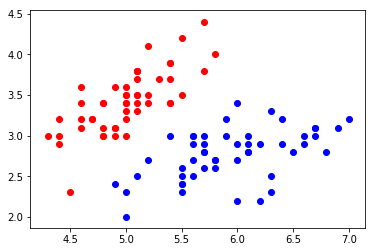

In [76]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
data = load_iris()
X = data.data
y = data.target
X = X[y!=2,:2]
y = y[y!=2]
y[y==0] = -1
X_train,X_test,y_train,y_test = train_test_split(X,y)
plt.scatter(X[y==1,0],X[y==1,1],color="blue")
plt.scatter(X[y==-1,0],X[y==-1,1],color='red')

In [77]:
clf = Adaboost()
clf.fit(X_train,y_train)

D= [0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333]
alpha= 1.1367987780603968
D= [0.00735294 0.00735294 0.07142857 0.00735294 0.00735294 0.00735294
 0.00735294 0.00735294 0.00735294 0.00735294 0.00735294 0.0073

In [78]:
clf.score(X_test,y_test)

1.0

In [68]:
pre != y_test

array([False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False,  True,
        True, False, False, False, False, False, False])

In [63]:
clf.weakclass_

[{'bestlabel': 2, 'bestsplit': 2.45, 'symbol': 1}]